In [1]:
import pandas as pd
import numpy as np
from patternly.detection import ContinuousStreamingDetection, StreamingDetection
from sklearn.cluster import KMeans
from IPython.display import Image, display
from IPython.core.display import HTML

## Method 1

This first example will demonstrate the use of `patternly` using a specified number of clusters (`N_CLUSTERS`) determined a priori. In this case, the number of clusters was determined somewhat arbitrarily.

In [2]:
# Satellite data we will be analyzing
original = pd.read_csv("./data/01_2015_LANL-01A_SOPA_MPA.txt", low_memory=False).dropna(how="any", axis=0)
original = original.replace(-1e+31, np.nan).dropna().reset_index(drop=True)

# Parameters for patternly
START_COL = 1
END_COL = 4
WINDOW_SIZE = 1000
WINDOW_OVERLAP = 0
N_CLUSTERS = 2

The below code iterates over 4 different streams of data. Each stream is first partitioned into windows using the specified window size and overlap. We then calculate the distance matrix of the windows with respect to each other and cluster each entry into 1 of the specified clusters using kmeans. For each cluster we generate a PFSA.

We then use these PFSAs to predict the likelihood of each window belonging to each of the clusters. If the likelihood is beyond a certain threshold, it is categorized as anomalous.

In [3]:
cols = original.columns[START_COL:END_COL]
predictions = []
pipelines = []
for col in cols:
    pipelines.append(
        StreamingDetection(
            window_size=WINDOW_SIZE,
            window_overlap=WINDOW_OVERLAP,
            anomaly_sensitivity=1,
            n_clusters=N_CLUSTERS,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
            reduce_clusters = False,
        )
    )
    pipelines[-1].fit(original[col])
    predictions.append(pd.DataFrame(pipelines[-1].predict()))

predictions = pd.concat(predictions, axis=1)
predictions.columns = range(predictions.shape[1])

We then plot the results below, color coding each of the found clusters and highlighting the anomalies in red.

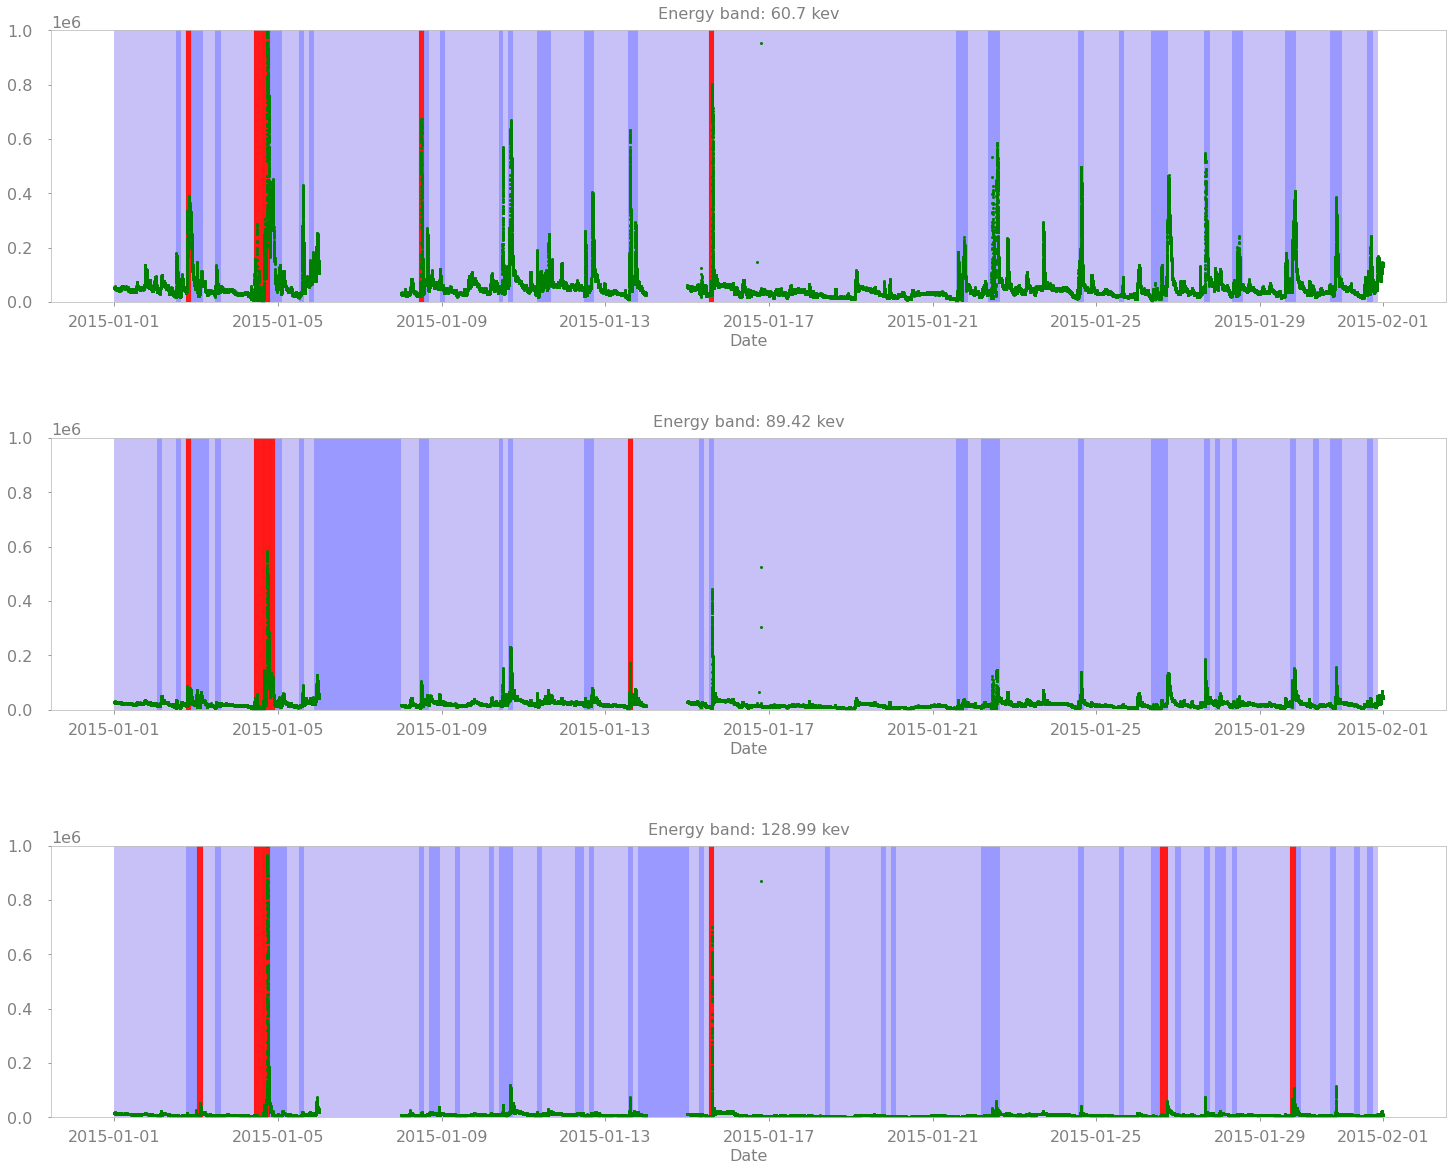

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.rcParams["figure.figsize"] = (25, 20)
plt.subplots_adjust(hspace=.5)
    
start = datetime.strptime(original['DATE'].iloc[0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original['DATE'].iloc[-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan']

for i, col in enumerate(cols):
    seqs = original[col].to_frame()
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    anoms = list(predictions[predictions[i] == True].index)        
    for index in predictions.index:
        beg = data["ts"].iloc[index * WINDOW_SIZE]
        end = data["ts"].iloc[index * WINDOW_SIZE + WINDOW_SIZE]
        if index in anoms:
            plt.axvspan(beg, end, color='red', alpha=0.9, lw=0.1)
        else:
            color = colors[pipelines[i].closest_match[index]]
            plt.axvspan(beg, end, color=color, alpha=0.4, lw=0)

    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f'Energy band: {col} kev', fontsize=16, y=1.02, color='.5')
    ax.set_xlabel('Date',fontsize=16, color='.5')

## Method 2

Next, we can look at a continuously streaming model. We still split the data streams into windows, however, in contrast to the previous example, here we do not specify the number of clusters to find a priori. Instead, we keep track of a PFSA library and continuously update this library when encountering a window that does not conform to any of the PFSAs in the established library.

In [8]:
from patternly.detection import ContinuousStreamingDetection

continuous_predictions = []
continuous_pipelines = []
for col in cols:
    continuous_pipelines.append(
        ContinuousStreamingDetection(
            window_size=WINDOW_SIZE,
            window_overlap=WINDOW_OVERLAP,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
            reduce_clusters = False,
        )
    )
    continuous_pipelines[-1].fit_stream(original[col])
    continuous_predictions.append(pd.DataFrame(continuous_pipelines[-1].predict()))

continuous_predictions = pd.concat(continuous_predictions, axis=1)
continuous_predictions.columns = range(continuous_predictions.shape[1])

Once again we will plot the results.

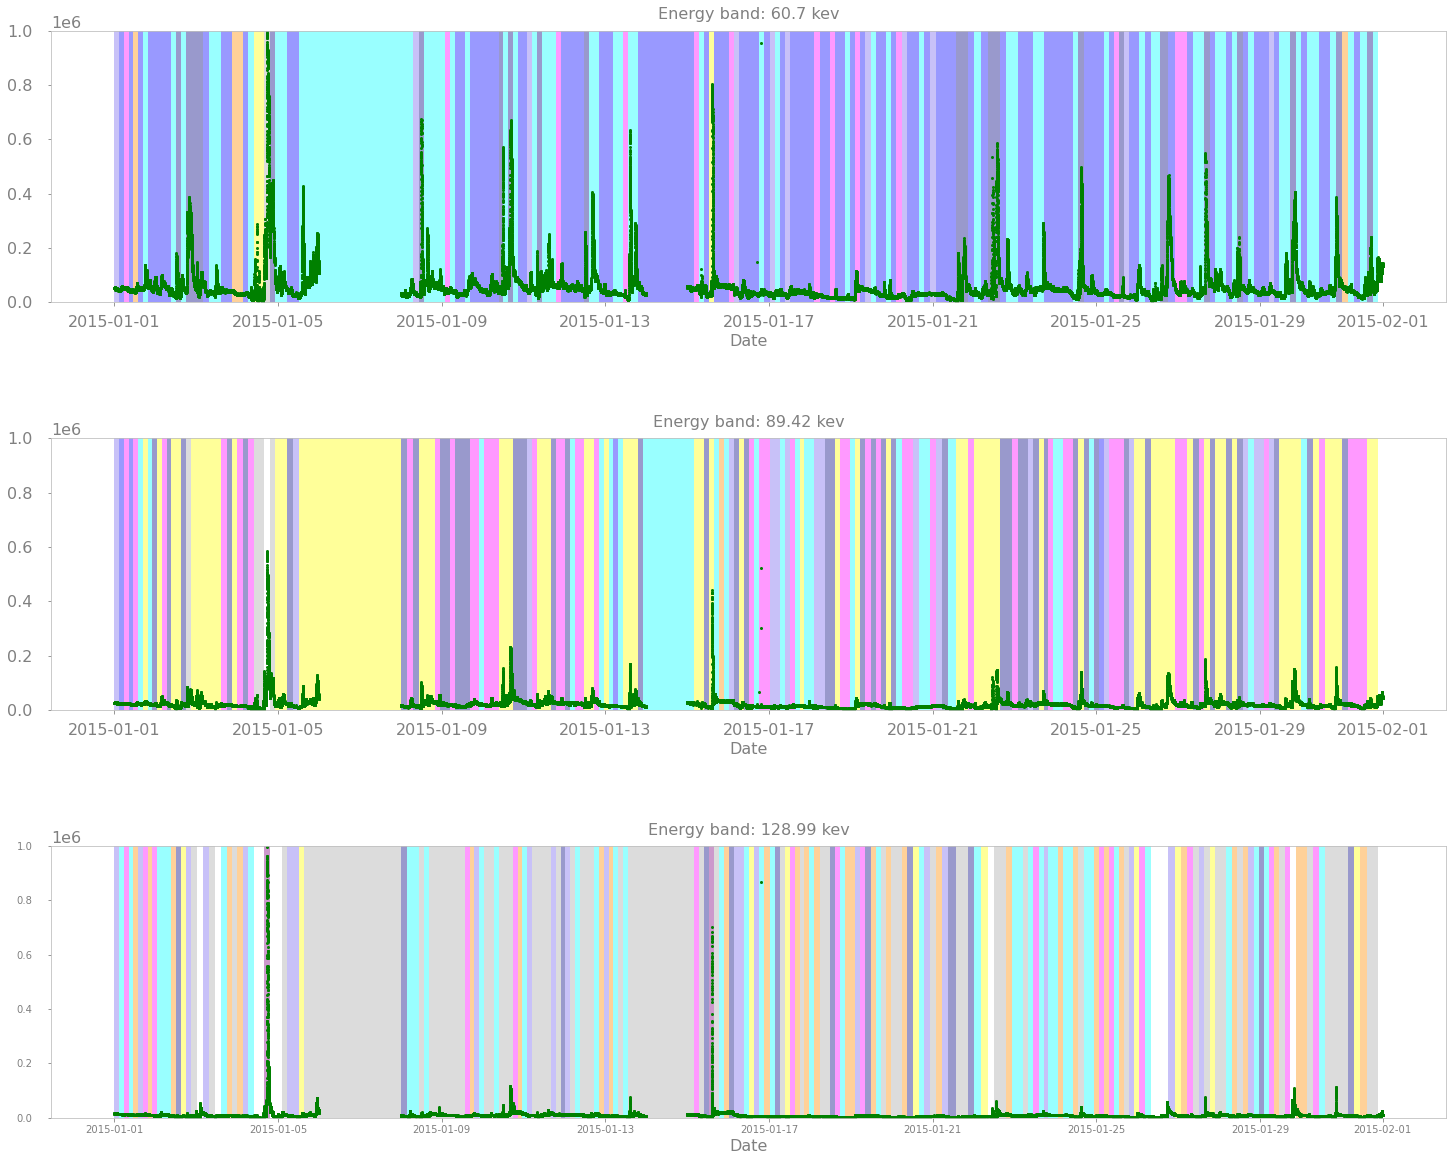

In [9]:
plt.rcParams["figure.figsize"] = (25, 20)
plt.subplots_adjust(hspace=.5)
    
start = datetime.strptime(original['DATE'].iloc[0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original['DATE'].iloc[-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

colors = [
    "#7766ee", "blue", "magenta", "darkorange", 'cyan', "navy", 
    "yellow", "darkgray", "white", "purple", "skyblue", "gray",
    "violet", "gold", "seagreen", "lime"
]

for i, col in enumerate(cols):
    seqs = original[col].to_frame()
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    anoms = list(continuous_predictions[continuous_predictions[i] == True].index)        
    for index in continuous_predictions.index:
        beg = data["ts"].iloc[index * WINDOW_SIZE]
        end = data["ts"].iloc[index * WINDOW_SIZE + WINDOW_SIZE]
        if index in anoms:
            plt.axvspan(beg, end, color='red', alpha=0.9, lw=0.1)
        else:
            color = colors[continuous_pipelines[i].closest_match[index]]
            plt.axvspan(beg, end, color=color, alpha=0.4, lw=0)

    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax = plt.gca()
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f'Energy band: {col} kev', fontsize=16, y=1.02, color='.5')
    ax.set_xlabel('Date',fontsize=16, color='.5')

In this case, we see there were too many clusters found. We need a way to reduce this and the chosen method was to use embedding and pca to reduce dimensionality, then use DBSCAN to cluster similar clusters together.

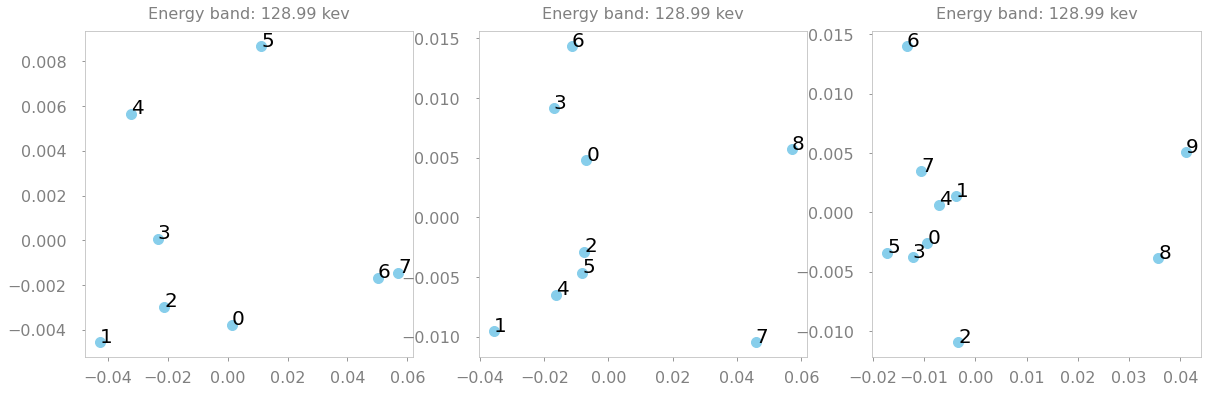

In [11]:
import subprocess
from zedsuite.zutil import Prun, Lsmash
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
plt.rcParams["figure.figsize"] = (20, 6)

# reduce clusters by combining similar ones
new_label_map_list = []
for i, pipeline in enumerate(continuous_pipelines):
    # use prun to generate sequences for each PFSA in the established library
    representative_seqs = []
    for pfsa in pipeline.cluster_PFSA_files:
        representative_seqs.append(Prun(pfsafile=pfsa, data_len=pipeline.window_size, num_repeats=10000).run()[0])
        
    # use lsmash and embed results to use pca to map to 2 dimensions
    pd.DataFrame(
        Lsmash(data=pd.DataFrame(representative_seqs), data_type='symbolic', sae=False).run(),
        dtype=np.float32
    ).to_csv(f"for_embedding-{i}", sep=' ', header=False, index=False)
    subprocess.run(["./bin/embed", "-f", f"for_embedding-{i}", "-E", f"embedding-{i}"], capture_output=True)
    pca = PCA(n_components=2)
    embedded_pca = pca.fit_transform(pd.read_csv(f"embedding-{i}", sep=' ', header=None, dtype=np.float32).dropna(how='any', axis=1).T)
    X = embedded_pca.T[0]
    y = embedded_pca.T[1]
    plt.subplot(1, 3, i+1)
    plt.scatter(X, y, s=100, color="skyblue")
        
    # cluster similar PFSAs from pca
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(embedded_pca)
    new_labels = []
    labels_iter = max(clustering.labels_) + 1
    for l in clustering.labels_:
        if l < 0:
            new_labels.append(labels_iter)
            labels_iter += 1
        else:
            new_labels.append(l)

    new_label_map = dict(zip(range(pipeline.n_clusters), new_labels))
    new_label_map_list.append(new_label_map)
    
    # apply plotting labels to each cluster
    annotations = [str(i) for i in range(pipeline.n_clusters)]
    for j, label in enumerate(annotations):
        plt.annotate(label, (X[j], y[j]), fontsize=20)
    
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5',pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f'Energy band: {col} kev',fontsize=16,y=1.02,color='.5')

We can then plot the results with reduced clusters. 

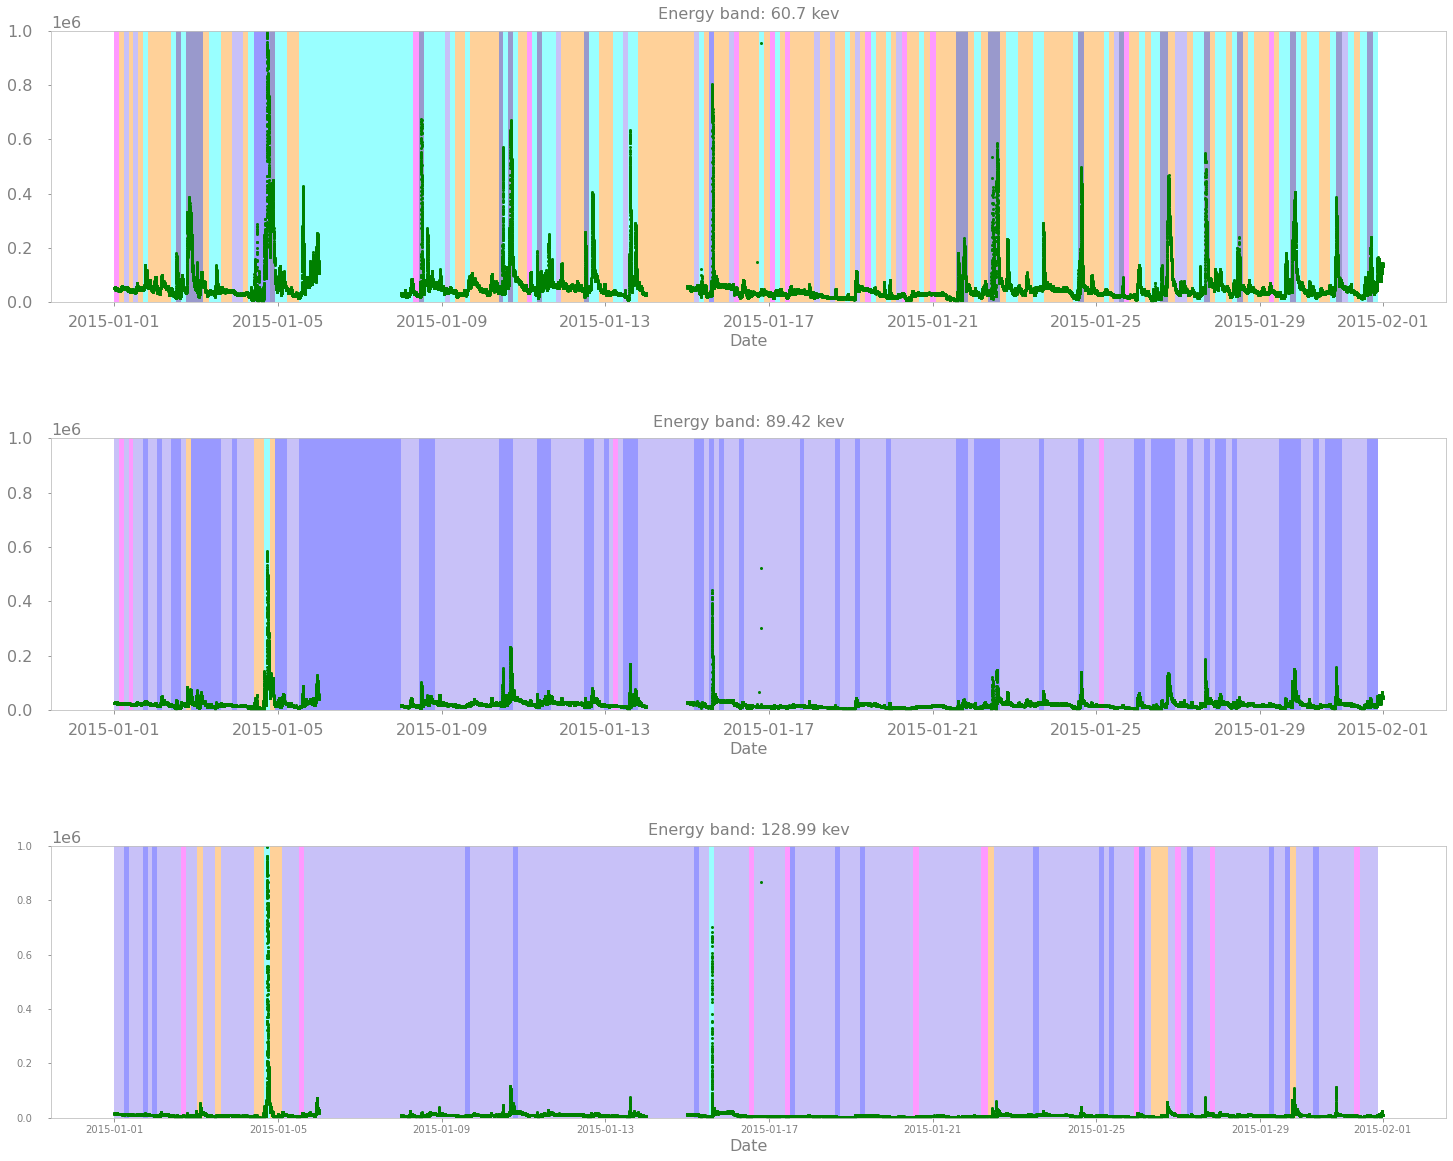

In [12]:
plt.rcParams["figure.figsize"] = (25, 20)
plt.subplots_adjust(hspace=.5)

for i, col in enumerate(cols):
    new_label_map = new_label_map_list[i]
    seqs = original[col].to_frame()
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    anoms = list(continuous_predictions[continuous_predictions[i] == True].index)        
    for index in continuous_predictions.index:
        beg = data["ts"].iloc[index * WINDOW_SIZE]
        end = data["ts"].iloc[index * WINDOW_SIZE + WINDOW_SIZE]
        if index in anoms:
            plt.axvspan(beg, end, color='red', alpha=0.9, lw=0.1)
        else:
            color = colors[new_label_map[continuous_pipelines[i].closest_match[index]]]
            plt.axvspan(beg, end, color=color, alpha=0.4, lw=0)

    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax = plt.gca()
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f'Energy band: {col} kev', fontsize=16, y=1.02, color='.5')
    ax.set_xlabel('Date',fontsize=16, color='.5')

As can be seen visually, we have successfully reduced the number of clusters by combining similar ones.

## Method 3

The final example will be a combination of the previously described techniques. We will split half of the data for each sequence into windows and find PFSAs for specified `N_CLUSTERS` as detailed in **Method 1**. Then we will split the second half for each channel into sequences and continuously update the PFSA library if a given sequence does not conform to any PFSAs in the established library as detailed in **Method 2**.

In [13]:
half_predictions = []
half_pipelines = []
for col in cols:
    data = original[col]
    data_1 = data.iloc[:data.shape[0]//2]
    data_2 = data.iloc[data.shape[0]//2:]
    half_pipelines.append(
        ContinuousStreamingDetection(
            window_size=WINDOW_SIZE,
            window_overlap=WINDOW_OVERLAP,
            n_clusters=N_CLUSTERS,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
            reduce_clusters = False,
        )
    )
    half_pipelines[-1].fit(data_1)
    half_pipelines[-1].fit_stream(data_2)
    half_predictions.append(pd.DataFrame(half_pipelines[-1].predict()))

half_predictions = pd.concat(half_predictions, axis=1)
half_predictions.columns = range(half_predictions.shape[1])

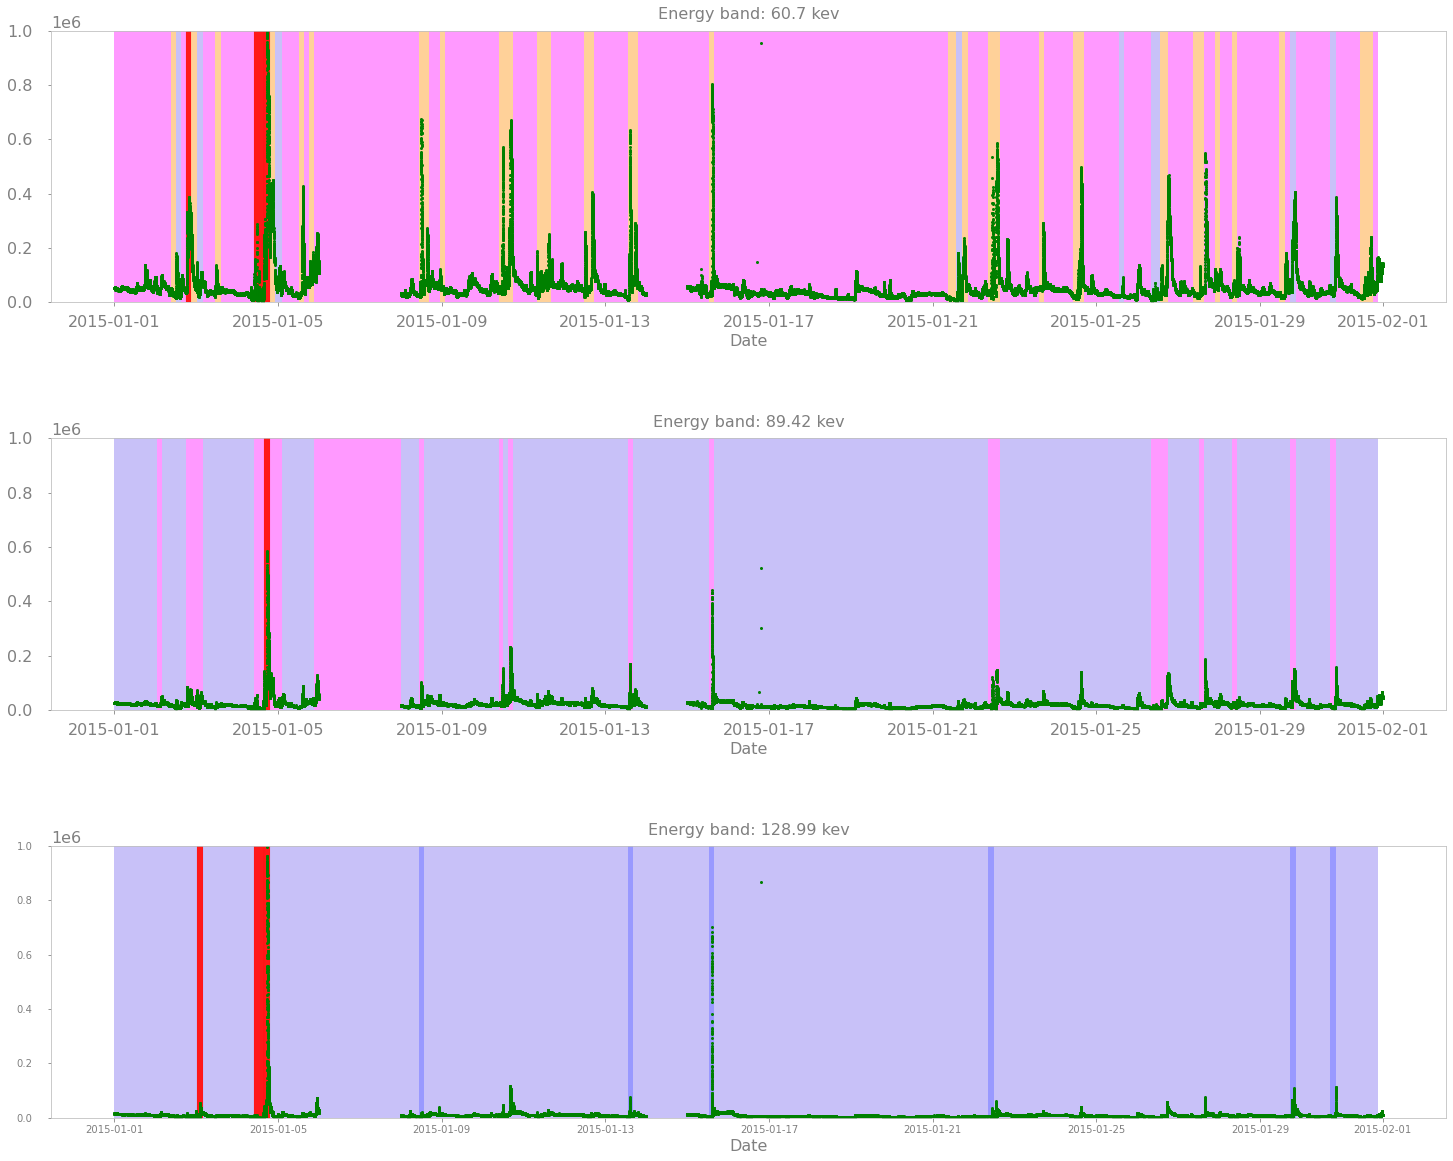

In [14]:
plt.rcParams["figure.figsize"] = (25, 20)
plt.subplots_adjust(hspace=.5)

for i, col in enumerate(cols):
    new_label_map = new_label_map_list[i]
    seqs = original[col].to_frame()
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    anoms = list(half_predictions[half_predictions[i] == True].index)        
    for index in half_predictions.index:
        beg = data["ts"].iloc[index * WINDOW_SIZE]
        end = data["ts"].iloc[index * WINDOW_SIZE + WINDOW_SIZE]
        if index in anoms:
            plt.axvspan(beg, end, color='red', alpha=0.9, lw=0.1)
        else:
            color = colors[new_label_map[half_pipelines[i].closest_match[index]]]
            plt.axvspan(beg, end, color=color, alpha=0.4, lw=0)

    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax = plt.gca()
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title(f'Energy band: {col} kev', fontsize=16, y=1.02, color='.5')
    ax.set_xlabel('Date',fontsize=16, color='.5')